In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
from dateutil import parser
from hampel import hampel
import score_inference as score
from statsmodels.graphics.tsaplots import plot_acf


   0-0  0-1  1-0  1-1  2-0  0-2  2-1  1-2  2-2  3-0  0-3  3-1  1-3       3-2  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.598172   

        2-3   V1   V2    r1_win    r2_win  
0  0.401828  0.0  0.0  0.598172  0.401828  


In [2]:
def get_data(file):
    data_list = []
    for line in open(file, 'r'):
        data_list.append(json.loads(line))

    with open(file, 'r') as f:
        top = f.readline()
        top = json.loads(top)

    runner_id = top['mc'][0]['marketDefinition']['runners'][0]['id']
    runner_id_2 = top['mc'][0]['marketDefinition']['runners'][1]['id']
    runner_name = top['mc'][0]['marketDefinition']['runners'][0]['name']
    runner_name_2 = top['mc'][0]['marketDefinition']['runners'][1]['name']
    market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
    r1_result = data_list[-1]['mc'][0]['marketDefinition']['runners'][0]['status']
    market_timestamp = datetime.timestamp(market_datetime) * 1000
    return data_list, runner_id, runner_id_2, runner_name, runner_name_2, r1_result, market_timestamp


def get_list(runner_id, data_list, market_timestamp):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2, r1_result):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)

    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df_avg_odds = df.resample('2000ms').last()
    last_index = df_avg_odds.last_valid_index() + pd.Timedelta(2, 'sec')
    final_index = last_index + pd.Timedelta(6, 'min')
    df_datetime = pd.date_range(last_index, final_index, freq='2000ms')
    print(df_datetime)
    if r1_result == 'WINNER':
        df_ones = pd.DataFrame({'runner 1': np.ones(181), '1 - runner 2': np.ones(181), 'avg': np.ones(181)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_ones])
    else:
        df_zeros = pd.DataFrame({'runner 1': np.zeros(181), '1 - runner 2': np.zeros(181), 'avg': np.zeros(181)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_zeros])
    print(df_avg_odds)
    return df_avg_odds

def get_best_pricevol(runner_list, price, vol):
# Function to get best lay and back information
    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.min(), item[1]])
                    back_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    back_list.append([item[0]['atl'][0][0], item[1]])
                    back_vol.append([item[0]['atl'][0][1], item[1]])

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.max(), item[1]])
                    lay_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    lay_list.append([item[0]['atb'][0][0], item[1]])
                    lay_vol.append([item[0]['atb'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))
# Apply hampel filter to remove outliers
    back_outliers = hampel(back_series, window_size=80)
    lay_outliers = hampel(lay_series, window_size=80)
    back_vol_outliers = hampel(back_vol_series, window_size=15)
    lay_vol_outliers = hampel(lay_vol_series, window_size=15)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):
# Get back and lay information and calculate spread and price up probability
    end_time = end + pd.Timedelta(120, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    df_datetime = df_datetime.floor('100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back_vol': dt_shape, 'lay_vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)

    _2000ms = df.index.floor('2000ms')
    idx_back = df.groupby(_2000ms)['back'].idxmin()
    idx_lay = df.groupby(_2000ms)['lay'].idxmax()
    df = df.resample('2000ms').mean().assign(back=df.loc[idx_back]['back'].values,
                                            back_vol=df.loc[idx_back]['back_vol'].values,
                                            lay=df.loc[idx_lay]['lay'].values,
                                            lay_vol=df.loc[idx_lay]['lay_vol'].values)

    df_best = df.rolling('60S').mean()
    df_best = df_best.loc[start:end]
    # last_index = end + pd.Timedelta(1, 'sec')
    # final_index = last_index + pd.Timedelta(59, 'sec')
    # df_datetime_new = pd.date_range(last_index, final_index, freq='2000ms')
    # print(end, last_index)
    # if r1_result == 'WINNER':
    #     df_ones = pd.DataFrame({'back': np.repeat(1000, 60), 'back_vol': np.zeros(60), 'lay': np.repeat(1000, 60), 'lay_vol': np.repeat(0.001, 60)}, index=df_datetime_new)
    #     df_best = pd.concat([df_best, df_ones])
    # else:
    #     df_zeros = pd.DataFrame({'back': np.ones(60), 'back_vol': np.zeros(60), 'lay': np.ones(60), 'lay_vol': np.repeat(0.001, 60)}, index=df_datetime_new)
    #     df_best = pd.concat([df, df_zeros])
    df_best['back-lay avg'] = df_best[['back', 'lay']].mean(axis=1)
    df_best['spread'] = df_best['back'] - df_best['lay']
    df_best['vol diff'] = df_best['back_vol'] - df_best['lay_vol']
    df_best['uncertainty'] = df_best['spread'] / df_best['back-lay avg']
    df_pup = df_best['back_vol'] / ( df_best['back_vol'] + df_best['lay_vol'] )
    df_pup.name = 'pup'
    df_best = pd.concat([df_best, df_pup], axis=1)
    df_best.fillna(method='ffill', inplace=True)

    return df_best

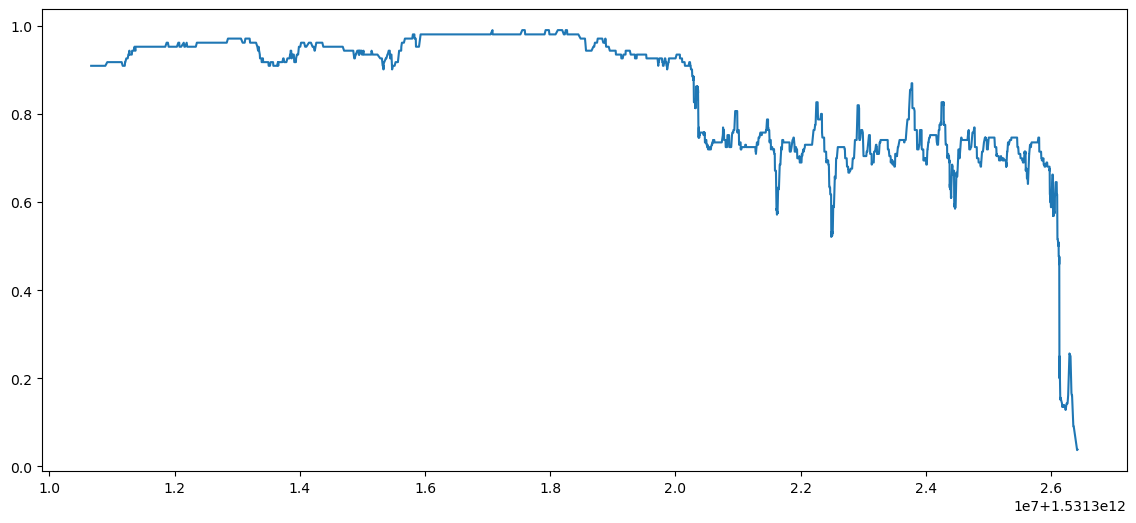

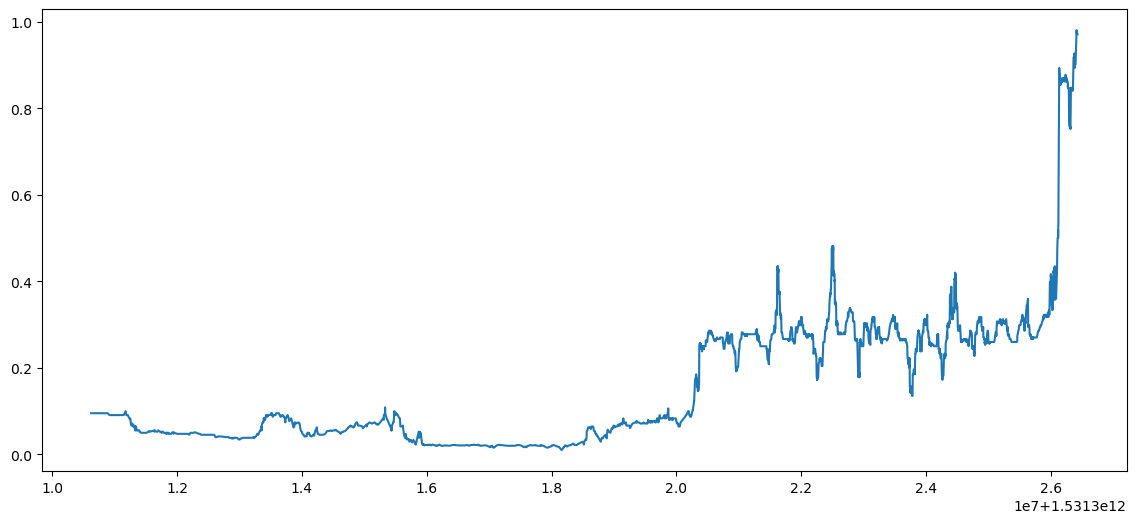

In [3]:
file = 'Wimbledon/1.145392229.json'
data_list, runner_id, runner_id_2, runner_name, runner_name_2, r1_result, market_timestamp = get_data(file)
runner_list_1 = get_list(runner_id, data_list, market_timestamp)
runner_list_2 = get_list(runner_id_2, data_list, market_timestamp)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [4]:
df = odds_avg(runner_odds_1, runner_odds_2, r1_result)
df

DatetimeIndex(['2018-07-11 16:27:06', '2018-07-11 16:27:08',
               '2018-07-11 16:27:10', '2018-07-11 16:27:12',
               '2018-07-11 16:27:14', '2018-07-11 16:27:16',
               '2018-07-11 16:27:18', '2018-07-11 16:27:20',
               '2018-07-11 16:27:22', '2018-07-11 16:27:24',
               ...
               '2018-07-11 16:32:48', '2018-07-11 16:32:50',
               '2018-07-11 16:32:52', '2018-07-11 16:32:54',
               '2018-07-11 16:32:56', '2018-07-11 16:32:58',
               '2018-07-11 16:33:00', '2018-07-11 16:33:02',
               '2018-07-11 16:33:04', '2018-07-11 16:33:06'],
              dtype='datetime64[ns]', length=181, freq='2000L')
                     runner 1  1 - runner 2       avg
2018-07-11 12:04:02  0.909091      0.904762  0.906926
2018-07-11 12:04:04  0.909091      0.904762  0.906926
2018-07-11 12:04:06  0.909091      0.904762  0.906926
2018-07-11 12:04:08  0.909091      0.904762  0.906926
2018-07-11 12:04:10  0.909091      0

,runner 1,1 - runner 2,avg
2018-07-11 12:04:02,0.909091,0.904762,0.906926
2018-07-11 12:04:04,0.909091,0.904762,0.906926
2018-07-11 12:04:06,0.909091,0.904762,0.906926
2018-07-11 12:04:08,0.909091,0.904762,0.906926
2018-07-11 12:04:10,0.909091,0.904762,0.906926
...,...,...,...
2018-07-11 16:32:58,0.000000,0.000000,0.000000
2018-07-11 16:33:00,0.000000,0.000000,0.000000
2018-07-11 16:33:02,0.000000,0.000000,0.000000
2018-07-11 16:33:04,0.000000,0.000000,0.000000


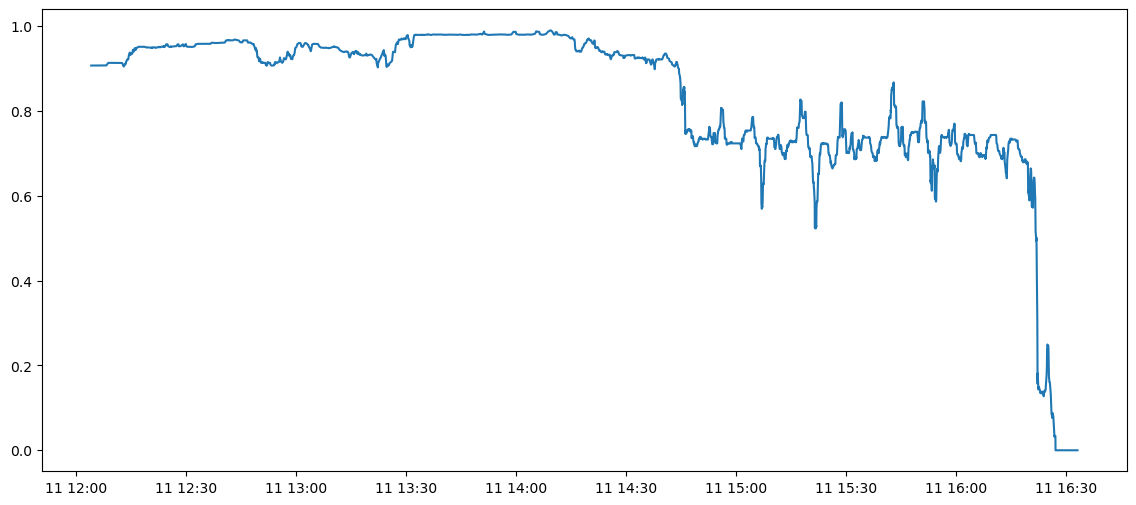

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])

In [6]:
start = df.first_valid_index()
end = df.last_valid_index()
df_score = score.get_score_time_series(df['avg'])

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
9 15
12 16
15 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
55 61
58 62
61 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
75 81
78 82
81 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 100
101 101
102 102
103 103
104 104
105 105
106 106
107 107
108 108
109 109
110 110
111 111
112 112
113 113
114 114
115 115
116 116
117 117
118 118
119 119
120 120
121 121
122 122
123 123
124 124
125 125
126 126
127 127
128 128
123 129
126 130
129 131
Match finished at 1-3


In [9]:
df_score

,r1_setscore,r2_setscore,markov_odds,match_score
2018-07-11 12:04:00,0,0,0.907076,0-0
2018-07-11 12:06:00,0,0,0.907076,0-0
2018-07-11 12:08:00,0,0,0.907076,0-0
2018-07-11 12:10:00,0,0,0.907076,0-0
2018-07-11 12:12:00,0,0,0.907076,0-0
...,...,...,...,...
2018-07-11 16:24:00,1,2,0.578098,1-2
2018-07-11 16:26:00,1,3,0.000000,1-3
2018-07-11 16:28:00,1,3,0.000000,1-3
2018-07-11 16:30:00,1,3,0.000000,1-3


In [10]:
df_enhanced = score.get_enhanced_markov_probs(df_score,runner_name,runner_name_2)

In [11]:
df_markov = pd.concat([df_score, df_enhanced], axis=1)

In [13]:
index_extend_markov = pd.date_range(df_markov.last_valid_index() + pd.Timedelta('2min'), df_markov.last_valid_index() + pd.Timedelta('10min'), freq='2min')
df_zeros = pd.DataFrame({'r1_setscore': np.repeat(420, 5), 'r2_setscore': np.repeat(420, 5), 'markov_odds': np.repeat(420, 5), 'match_score': np.repeat(420, 5), 'enhanced_markov_odds': np.repeat(420, 5)}, index=index_extend_markov)
df_markov_data = pd.concat([df_markov, df_zeros], axis=0)
df_markov_data.replace(420, method='ffill', inplace=True)
df_markov_data = df_markov_data.resample('2000ms').last()
df_markov_data.replace(np.nan, method='ffill', inplace=True)
df_markov_data = df_markov_data[start:end]
df_markov_data

,r1_setscore,r2_setscore,markov_odds,match_score,enhanced_markov_odds
2018-07-11 12:04:02,0.0,0.0,0.907076,0-0,0.72817
2018-07-11 12:04:04,0.0,0.0,0.907076,0-0,0.72817
2018-07-11 12:04:06,0.0,0.0,0.907076,0-0,0.72817
2018-07-11 12:04:08,0.0,0.0,0.907076,0-0,0.72817
2018-07-11 12:04:10,0.0,0.0,0.907076,0-0,0.72817
...,...,...,...,...,...
2018-07-11 16:32:58,1.0,3.0,0.000000,1-3,0.00000
2018-07-11 16:33:00,1.0,3.0,0.000000,1-3,0.00000
2018-07-11 16:33:02,1.0,3.0,0.000000,1-3,0.00000
2018-07-11 16:33:04,1.0,3.0,0.000000,1-3,0.00000


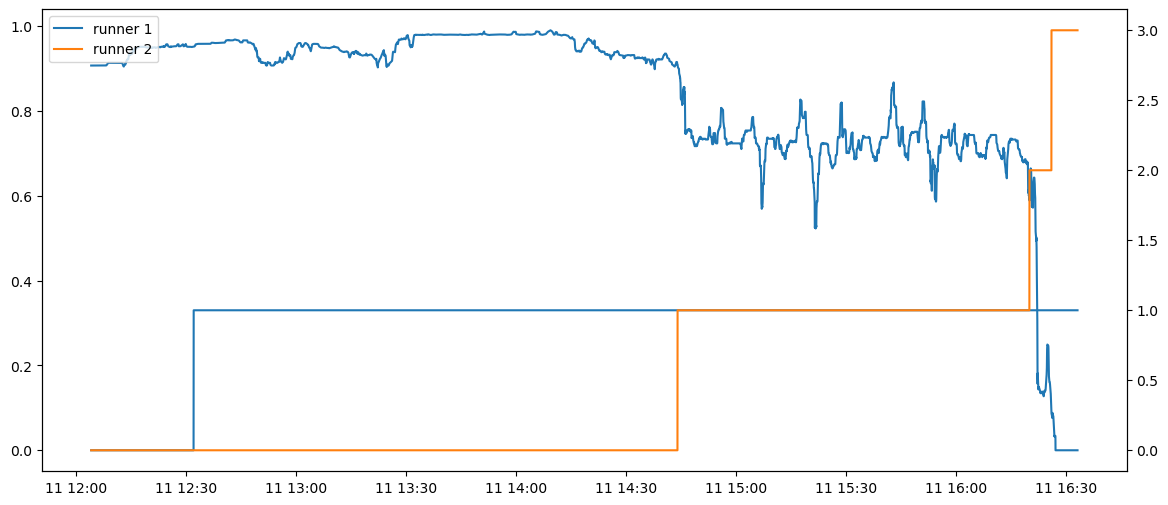

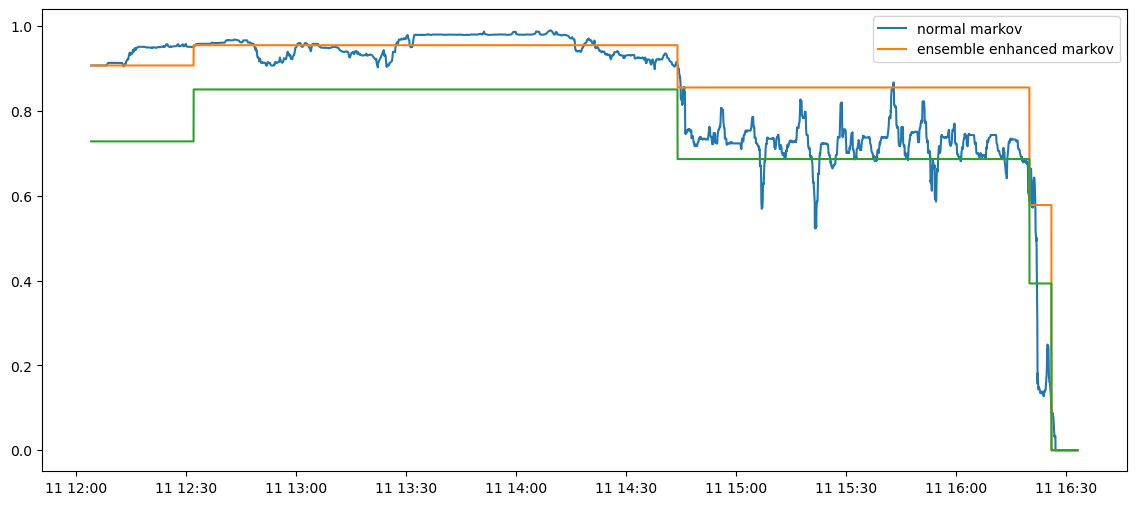

In [15]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['avg'])
ax2 = ax.twinx()
ax2.plot(df_markov_data['r1_setscore'])
ax2.plot(df_markov_data['r2_setscore'])
plt.legend(['runner 1', 'runner 2'])
plt.figure(figsize=(14,6))
plt.plot(df['avg'])
plt.plot(df_markov_data['markov_odds'])
plt.plot(df_markov_data['enhanced_markov_odds'])
plt.legend(['normal markov', 'ensemble enhanced markov'])

In [16]:
df_runner_1 = best_available_df(runner_list_1, start, end)
df_runner_1

,back,lay,back_vol,lay_vol,back-lay avg,spread,vol diff,uncertainty,pup
2018-07-11 12:04:02,1.11,1.090000,70646.770000,98325.850000,1.100000,0.020000,-27679.080000,0.018182,0.418096
2018-07-11 12:04:04,1.11,1.090000,70667.011833,98325.850000,1.100000,0.020000,-27658.838167,0.018182,0.418166
2018-07-11 12:04:06,1.11,1.090000,70687.253665,98325.850000,1.100000,0.020000,-27638.596335,0.018182,0.418235
2018-07-11 12:04:08,1.11,1.090000,70707.495498,98325.850000,1.100000,0.020000,-27618.354502,0.018182,0.418305
2018-07-11 12:04:10,1.11,1.086923,70727.737331,95542.472308,1.098462,0.023077,-24814.734977,0.021008,0.425378
...,...,...,...,...,...,...,...,...,...
2018-07-11 16:32:58,10.00,3.000000,20.000000,25.000000,6.500000,7.000000,-5.000000,1.076923,0.444444
2018-07-11 16:33:00,10.00,3.000000,20.000000,25.000000,6.500000,7.000000,-5.000000,1.076923,0.444444
2018-07-11 16:33:02,10.00,3.000000,20.000000,25.000000,6.500000,7.000000,-5.000000,1.076923,0.444444
2018-07-11 16:33:04,10.00,3.000000,20.000000,25.000000,6.500000,7.000000,-5.000000,1.076923,0.444444


In [17]:
df_runner_2 = best_available_df(runner_list_2, start, end)
df_runner_2

,back,lay,back_vol,lay_vol,back-lay avg,spread,vol diff,uncertainty,pup
2018-07-11 12:04:02,12.500000,8.60,367.880000,195.42,10.550000,3.900000,172.460000,0.369668,0.653080
2018-07-11 12:04:04,12.304878,8.60,369.532667,195.42,10.452439,3.704878,174.112667,0.354451,0.654095
2018-07-11 12:04:06,12.077236,8.60,369.785778,195.42,10.338618,3.477236,174.365778,0.336335,0.654250
2018-07-11 12:04:08,11.807927,8.60,447.711833,195.42,10.203963,3.207927,252.291833,0.314380,0.696143
2018-07-11 12:04:10,11.946341,8.60,431.573382,195.42,10.273171,3.346341,236.153382,0.325736,0.688322
...,...,...,...,...,...,...,...,...,...
2018-07-11 16:32:58,1.030000,1.03,41657.900000,3467.07,1.030000,0.000000,38190.830000,0.000000,0.923167
2018-07-11 16:33:00,1.030000,1.03,41657.900000,3467.07,1.030000,0.000000,38190.830000,0.000000,0.923167
2018-07-11 16:33:02,1.030000,1.03,41657.900000,3467.07,1.030000,0.000000,38190.830000,0.000000,0.923167
2018-07-11 16:33:04,1.030000,1.03,41657.900000,3467.07,1.030000,0.000000,38190.830000,0.000000,0.923167


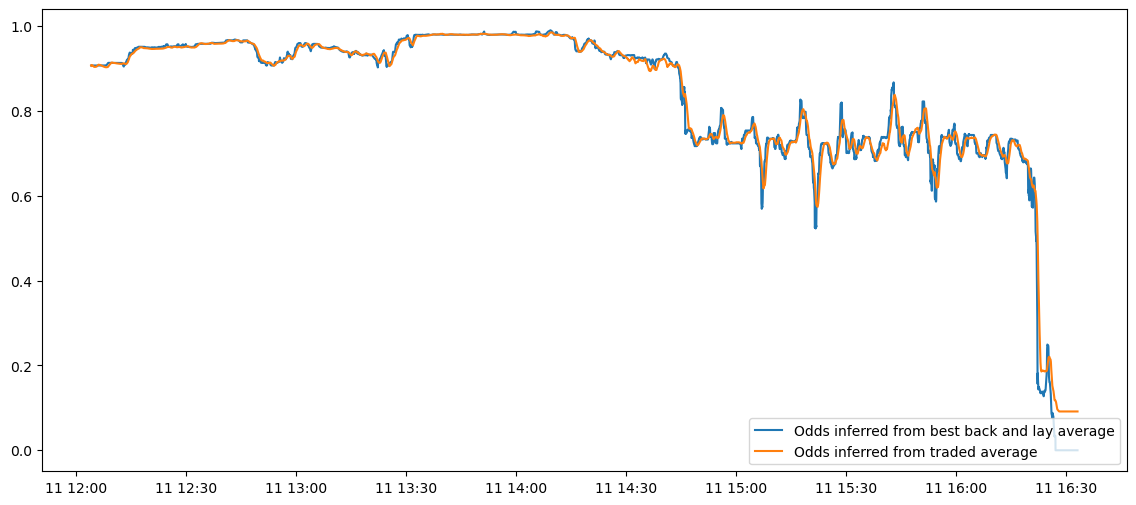

In [18]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
df_odds
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

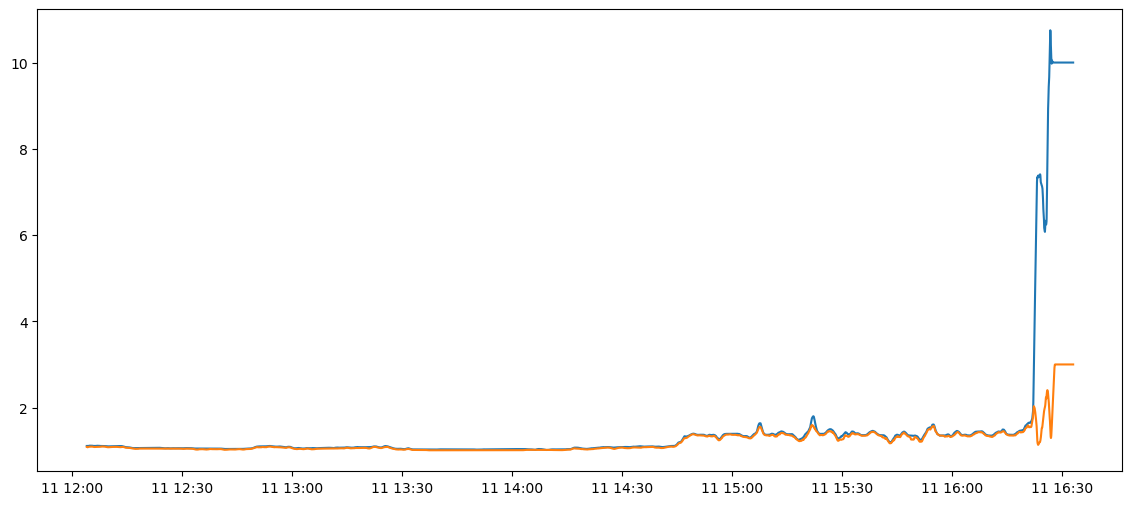

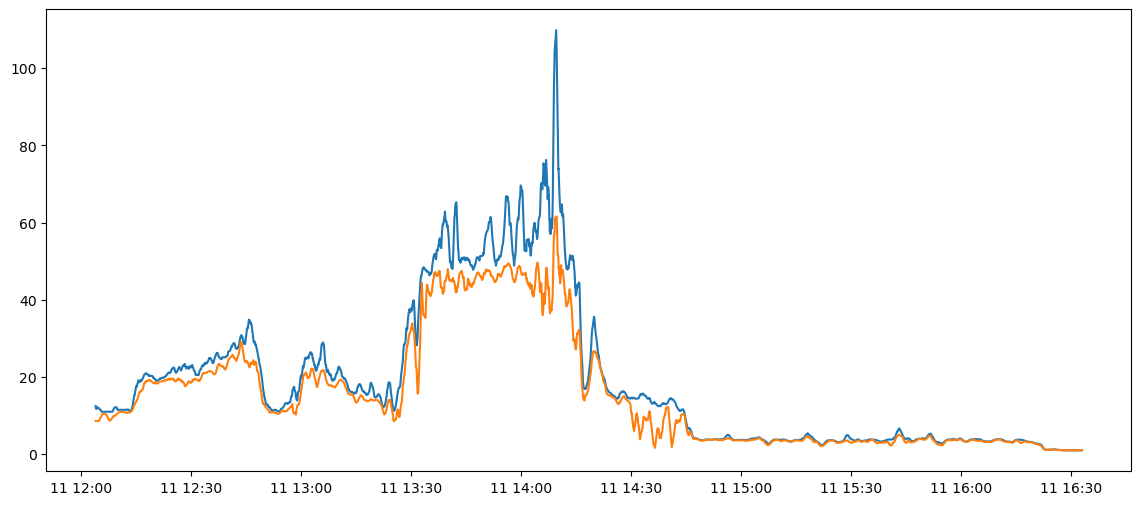

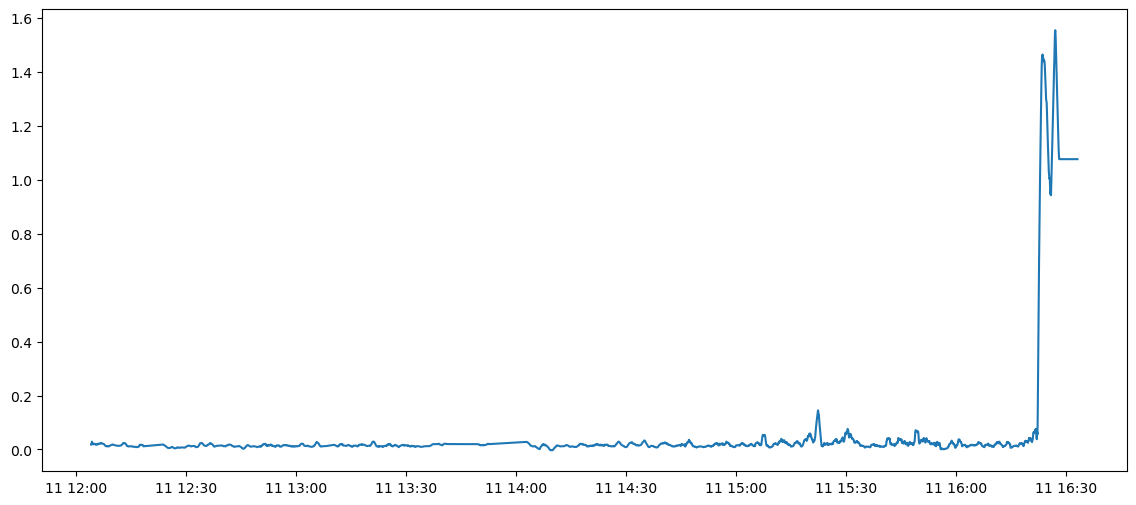

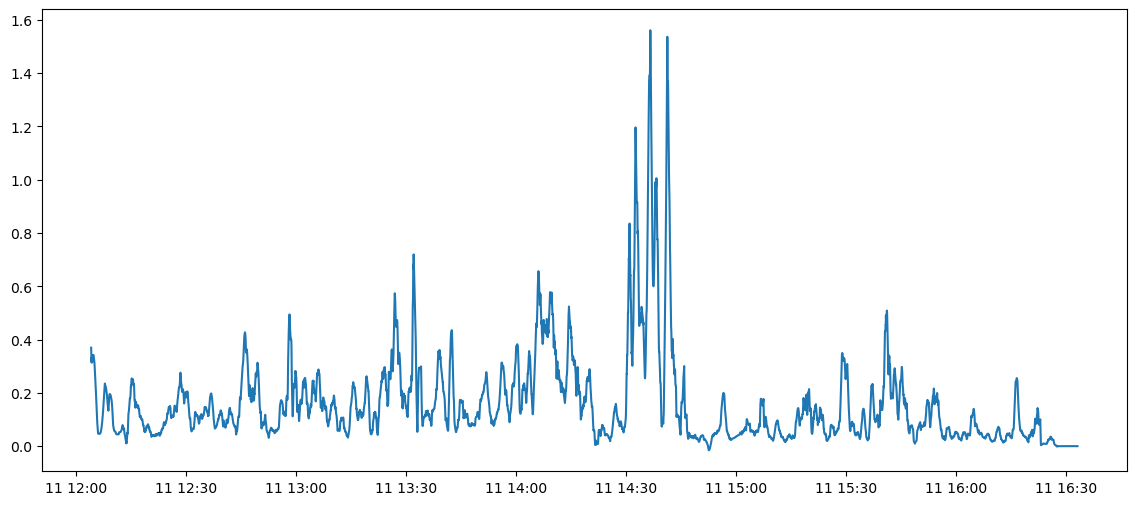

In [19]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['uncertainty']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['uncertainty']])

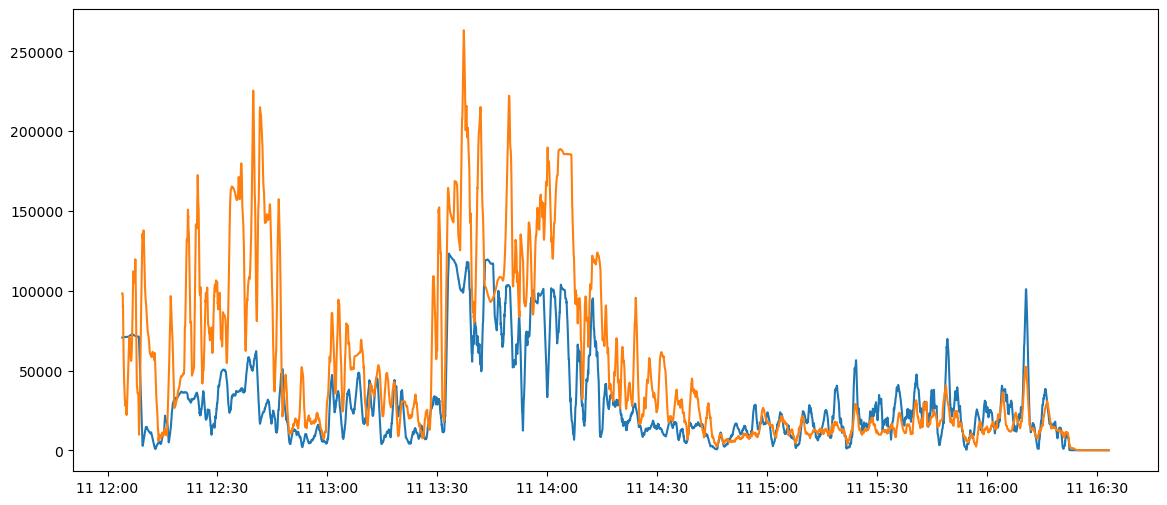

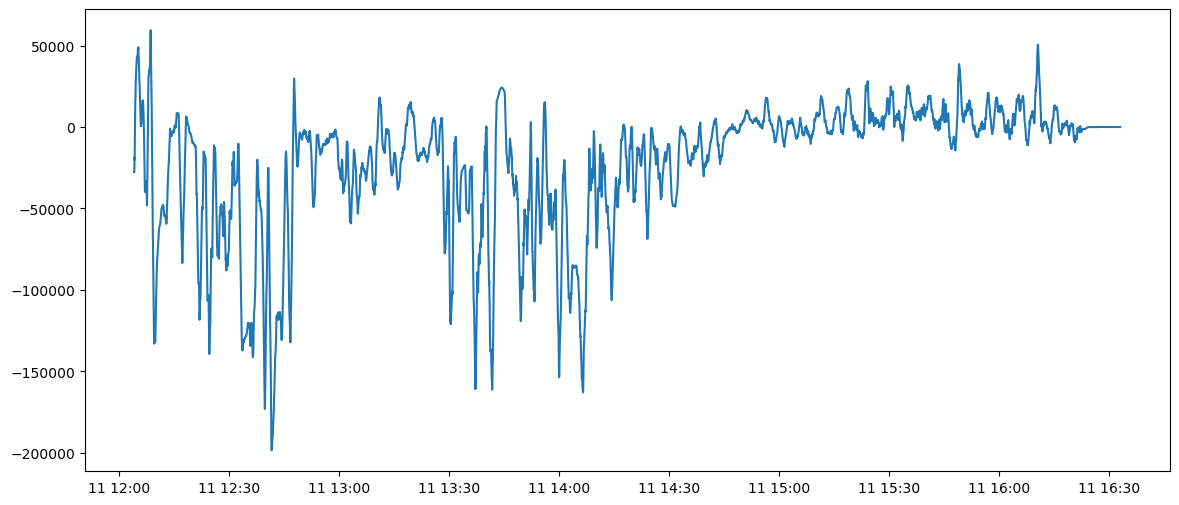

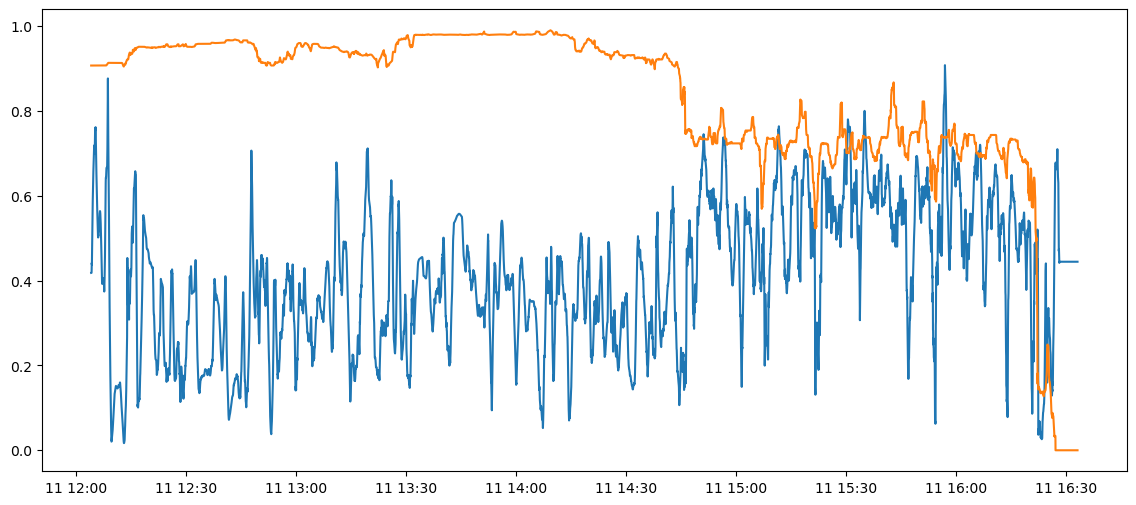

In [20]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back_vol']])
plt.plot(df_runner_1[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

,lpt odds,r1 spread,r1 pup,r2 spread,r2 pup,r1_sets_to_win,r2_sets_to_win,enhanced_markov
2018-07-11 12:04:02,0.906926,0.018182,0.418096,0.369668,0.653080,3.0,3.0,0.72817
2018-07-11 12:04:04,0.906926,0.018182,0.418166,0.354451,0.654095,3.0,3.0,0.72817
2018-07-11 12:04:06,0.906926,0.018182,0.418235,0.336335,0.654250,3.0,3.0,0.72817
2018-07-11 12:04:08,0.906926,0.018182,0.418305,0.314380,0.696143,3.0,3.0,0.72817
2018-07-11 12:04:10,0.906926,0.021008,0.425378,0.325736,0.688322,3.0,3.0,0.72817
...,...,...,...,...,...,...,...,...
2018-07-11 16:32:58,0.000000,1.076923,0.444444,0.000000,0.923167,2.0,0.0,0.00000
2018-07-11 16:33:00,0.000000,1.076923,0.444444,0.000000,0.923167,2.0,0.0,0.00000
2018-07-11 16:33:02,0.000000,1.076923,0.444444,0.000000,0.923167,2.0,0.0,0.00000
2018-07-11 16:33:04,0.000000,1.076923,0.444444,0.000000,0.923167,2.0,0.0,0.00000


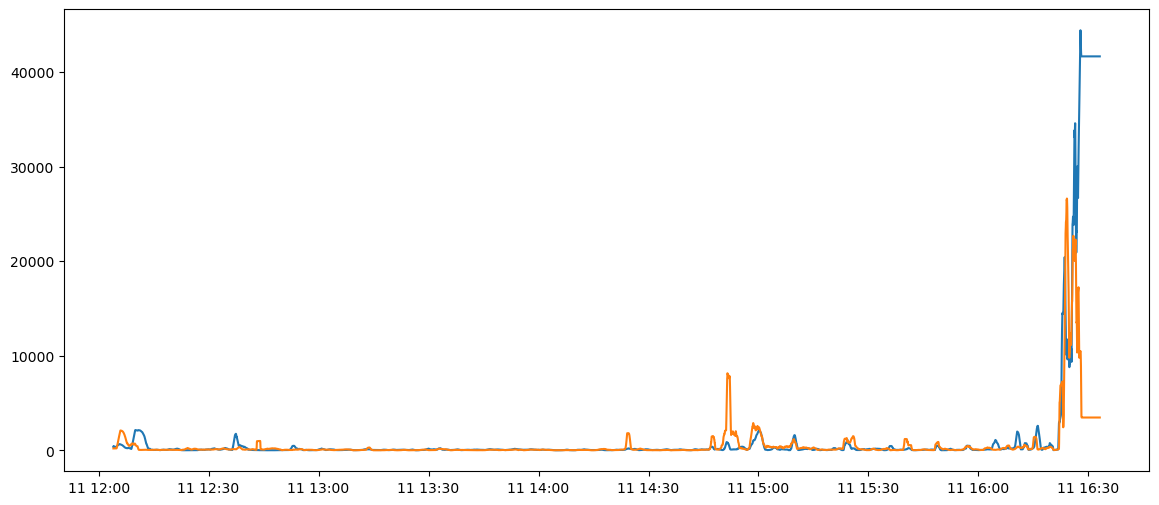

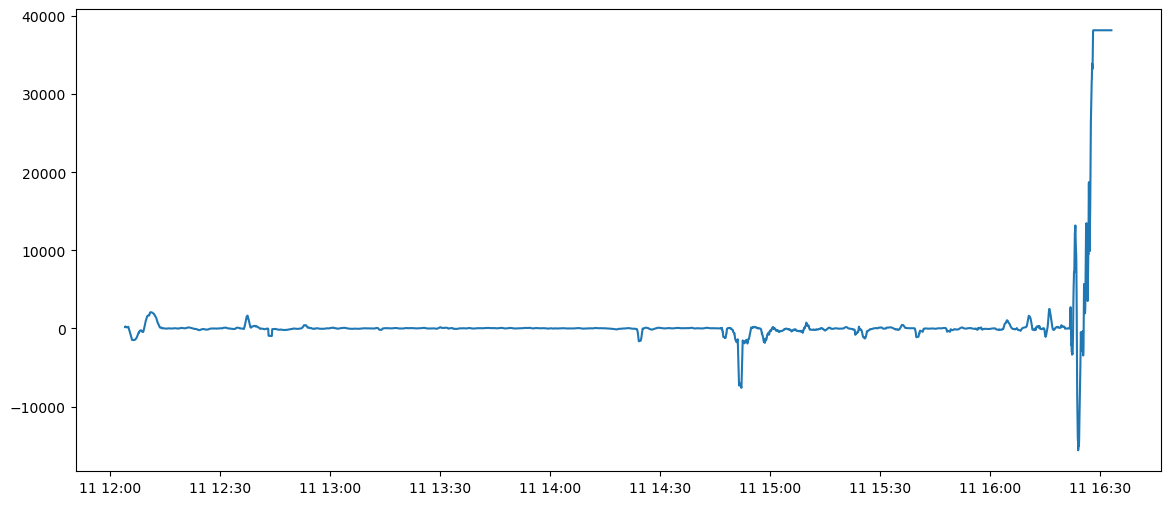

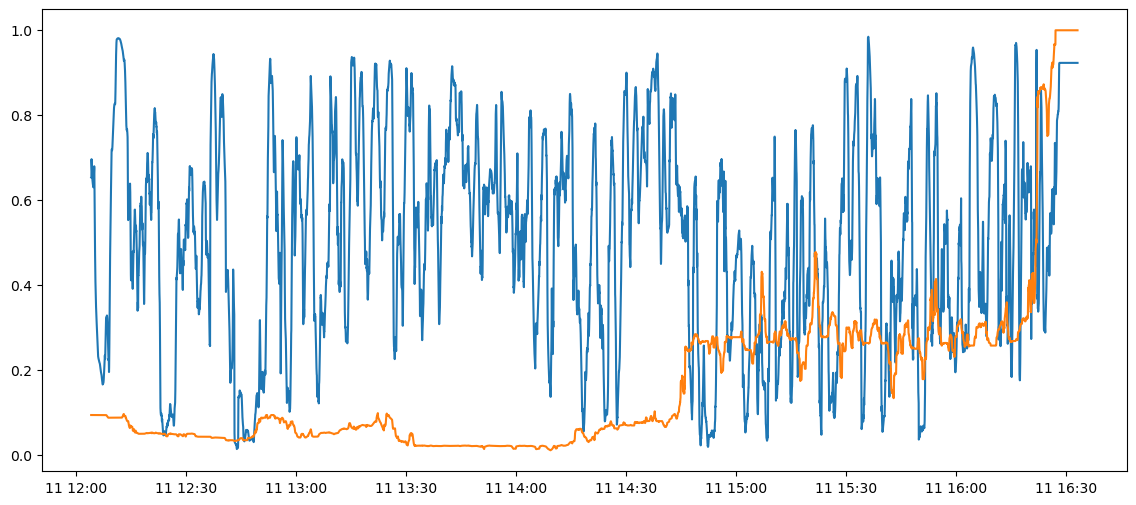

In [21]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back_vol']])
plt.plot(df_runner_2[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])
df_total = pd.DataFrame({'lpt odds': df_odds['ltp odds'], 'r1 spread': df_runner_1['uncertainty'], 'r1 pup': df_runner_1['pup'], 'r2 spread': df_runner_2['uncertainty'], 'r2 pup': df_runner_2['pup'], 'r1_sets_to_win': 3 - df_markov_data['r1_setscore'], 'r2_sets_to_win': 3 - df_markov_data['r2_setscore'], 'enhanced_markov': df_markov_data['enhanced_markov_odds']}, index=df_odds.index)
df_total.replace(to_replace=np.nan, method='ffill', inplace=True)
df_total.to_csv('Datatest/1.csv')
df_total

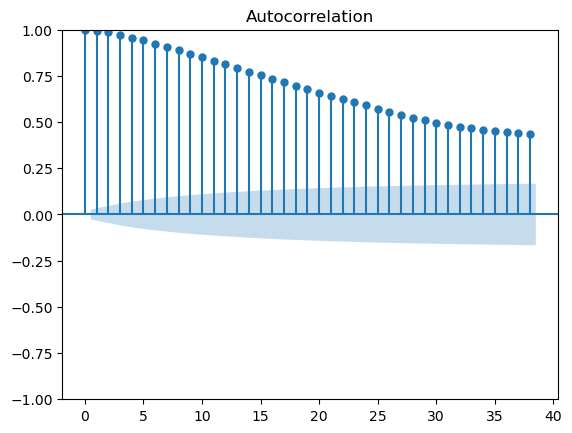

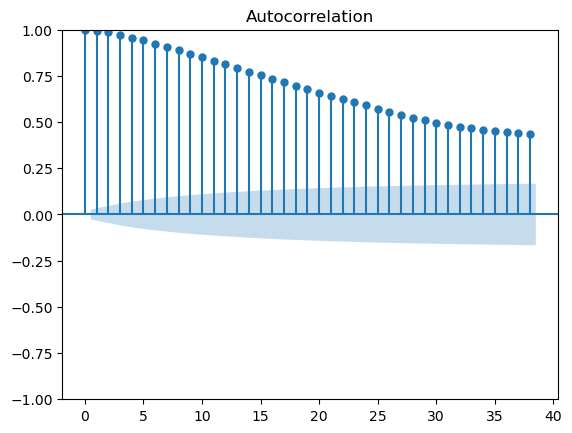

In [22]:
csv_file = 'Data/2249345v4423910.csv'
df_visualise = pd.read_csv(csv_file)
# s_odds = df_visualise['lpt odds']
# plot_acf(s_odds)
s_pup = df_visualise['r1 pup']
plot_acf(s_pup)